# Advanced Lane Finding Project

In [1]:
import cv2
import glob, os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline


### Camera Calibration

#### Computing the camera calibration matrix and distortion coefficients for a set of chessboard images & test images

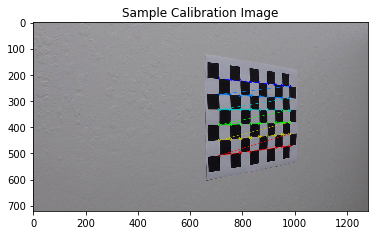

In [2]:
images = glob.glob('camera_cal/calibration*.jpg')

# object points in x and y direction
px = 9
py = 6

# prepare holders for object points in 3D and image points in 2D
obj_points = []
img_points = []

# generate coodinates for object points
objp = np.zeros((py*px,3), np.float32)
objp[:,:2] = np.mgrid[0:px, 0:py].T.reshape(-1,2)

for idx, fname in enumerate(images):
    
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (px,py), None)

    if ret == True:
        
        obj_points.append(objp)
        img_points.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
    

img_size = gray.shape[::-1]
plt.imshow(img)
plt.title('Sample Calibration Image')

# Camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points,
                                                   img_size[:2],None,None)
np.savetxt('cam_mtx.txt', mtx)
np.savetxt('cam_dist.txt', dist)

#### Distorted images to Undistorted images

In [ ]:
# mtx = np.loadtxt('cam_mtx.txt')
# dist = np.loadtxt('cam_dist.txt')

calib_images = glob.glob("camera_cal/calibration*.jpg")

cam_directory = "undistort_camera_cal"
if not os.path.exists(cam_directory):
    os.makedirs(cam_directory)

for idx, image_name in enumerate(calib_images):
    
    img = mpimg.imread(image_name)
    
    # undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # display results
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9)) # 
    f.tight_layout()
    
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(undist)
    ax2.set_title('Undistorted Image', fontsize=30)
    fname = 'undistort_' + image_name + '.jpg'
    f.savefig(fname)

test_images = glob.glob("test_images/*.jpg") 
test_directory = "undistort_test_images"
if not os.path.exists(test_directory):
    os.makedirs(test_directory)


for idx, image_name in enumerate(test_images):
    
    img = mpimg.imread(image_name)
    
    # undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(undist)
    ax2.set_title('Undistorted Image', fontsize=30)
    fname = 'undistort_' + image_name + '.jpg'
    f.savefig(fname)

### Image Thresholding for Binary image output : Colour thresholding &  Gradient thresholding

#### Visualization of lane lines displayed in RGB & HLS colour channels
#### ---For best selection of channels for yellow and white lane

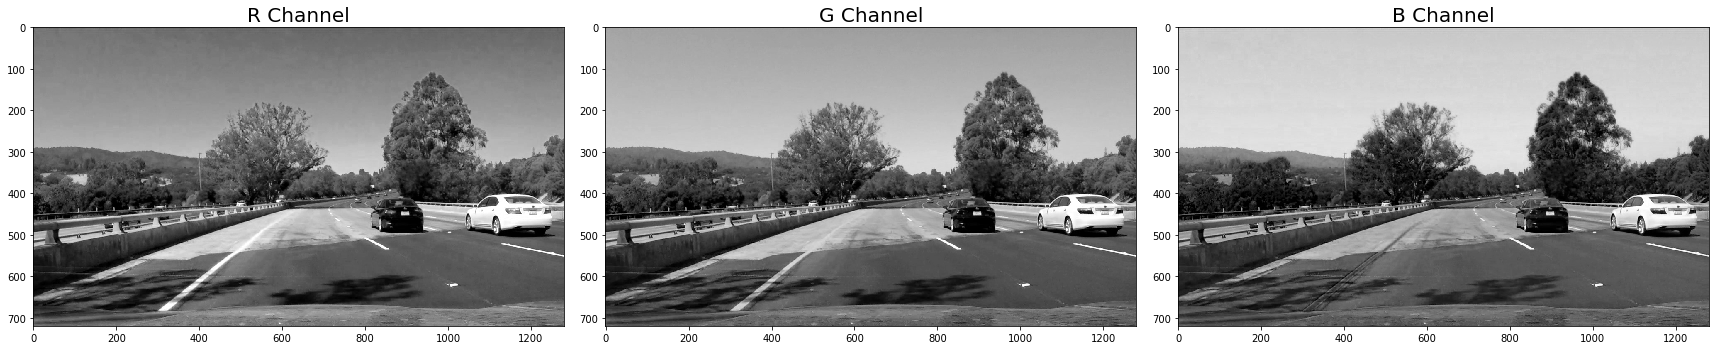

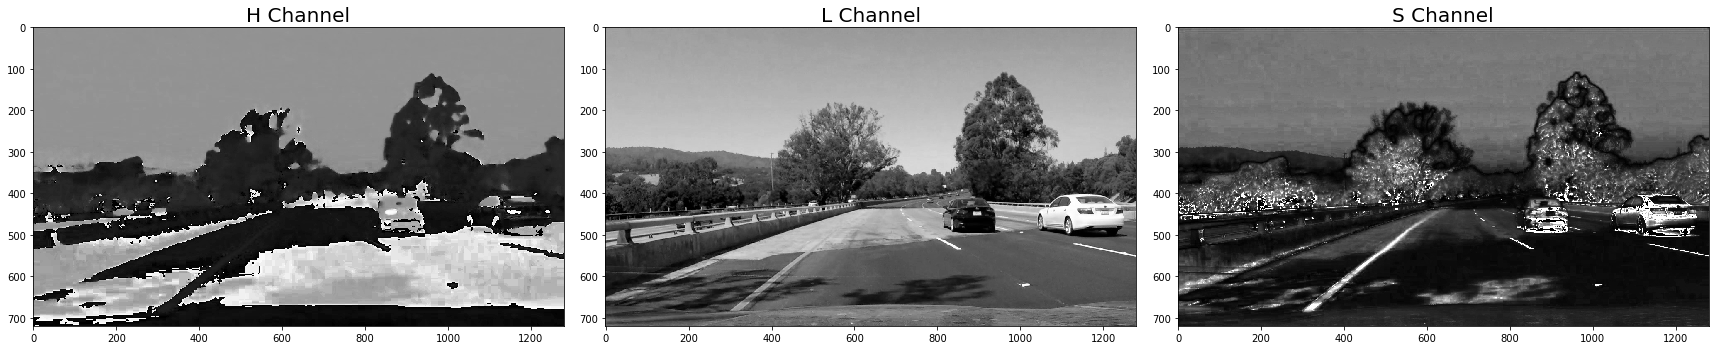

In [4]:
img = mpimg.imread('test_images/test4.jpg')

# for RGB colour space
r_channel = img[:,:,0]
g_channel = img[:,:,1]
b_channel = img[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(r_channel, cmap='gray')
ax1.set_title('R Channel', fontsize=20)
ax2.imshow(g_channel, cmap='gray')
ax2.set_title('G Channel', fontsize=20)
ax3.imshow(b_channel, cmap='gray')
ax3.set_title('B Channel', fontsize=20)
f.savefig('output_images/rgb_colourspace')

# for HLS colour space
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
h_channel = hls[:,:,0]
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(h_channel, cmap='gray')
ax1.set_title('H Channel', fontsize=20)
ax2.imshow(l_channel, cmap='gray')
ax2.set_title('L Channel', fontsize=20)
ax3.imshow(s_channel, cmap='gray')
ax3.set_title('S Channel', fontsize=20)
f.savefig('output_images/hls_colourspace')

In [5]:
def threshold_sobelx(img):
    """
    Return the gradient threshold S channel image

    """    
    s_thresh = [170, 255]
    sx_thresh = [25, 200]
    img = np.copy(img)
    # Convert to HLS color space and separate the L,S,R channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    
    s_channel = hls[:,:,2]
    
    
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    sobelx_binary = sxbinary

    return sobelx_binary

def bin_it(image, threshold):
    """
    converts a single channeled image to a binary image,
    using upper and lower threshold
    """
    assert len(image.shape) == 2
    
    output_bin = np.zeros_like(image)
    output_bin[(image >= threshold[0]) & (image <= threshold[1])]=1
    return output_bin

def threshold_colours(image):
    """
    Return binary image from thresholding colour channels
    
    """
    # convert image to hls colour space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    
    # binary threshold values
    bin_thresh = [20, 255]
    
    # rgb thresholding for yellow
    lower = np.array([225,180,0],dtype = "uint8")
    upper = np.array([255, 255, 170],dtype = "uint8")
    mask = cv2.inRange(image, lower, upper)
    rgb_y = cv2.bitwise_and(image, image, mask = mask).astype(np.uint8)
    rgb_y = cv2.cvtColor(rgb_y, cv2.COLOR_RGB2GRAY)
    rgb_y = bin_it(rgb_y, bin_thresh)
    
    # hls thresholding for yellow
    lower = np.array([20,120,80],dtype = "uint8")
    upper = np.array([45, 200, 255],dtype = "uint8")
    mask = cv2.inRange(hls, lower, upper)
    hls_y = cv2.bitwise_and(image, image, mask = mask).astype(np.uint8)
    hls_y = cv2.cvtColor(hls_y, cv2.COLOR_HLS2RGB)
    hls_y = cv2.cvtColor(hls_y, cv2.COLOR_RGB2GRAY)
    hls_y = bin_it(hls_y, bin_thresh)
    
    
    # rgb thresholding for white
    lower = np.array([100,100,200],dtype = "uint8")
    upper = np.array([255, 255, 255],dtype = "uint8")
    mask = cv2.inRange(image, lower, upper)
    rgb_w = cv2.bitwise_and(image, image, mask = mask).astype(np.uint8)
    rgb_w = cv2.cvtColor(rgb_w, cv2.COLOR_RGB2GRAY)
    rgb_w = bin_it(rgb_w, bin_thresh)

    
    im_bin = np.zeros_like(hls_y)
    im_bin [(rgb_y == 1)|(rgb_w==1)|(hls_y==1)]= 1
    
    return im_bin

def combine_binary(img1, img2):
    combined_binary = np.zeros_like(img1)
    combined_binary[(img1==1) | (img2==1)] = 1
    return combined_binary

def thresh_bin(image):
    img1 = threshold_colours(image)
    img2 = threshold_sobelx(image)
    c_img = combine_binary(img1, img2)
    return c_img

### Display combined binary image output after color threshold and gradient threshold

In [ ]:
test_images = glob.glob("test_images/*.jpg")
dirname = "threshold_test_images"
if not os.path.exists(dirname):
    os.makedirs(dirname)

for _, image_name in enumerate(test_images):
    img = mpimg.imread(image_name)

    c_threshold = threshold_colours(img)
    g_threshold = threshold_sobelx(img)
    combined_binary = combine_binary(c_threshold, g_threshold)

    f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(img, cmap='gray')
    ax1.set_title('Image', fontsize=20)
    ax2.imshow(c_threshold, cmap='gray')
    ax2.set_title('Colour Threshold', fontsize=20)
    ax3.imshow(g_threshold, cmap='gray')
    ax3.set_title('Gradient Threshold', fontsize=20)
    ax4.imshow(combined_binary, cmap='gray')
    ax4.set_title('Combined Binary', fontsize=20)
    fname = "threshold_" + image_name
    f.savefig(fname)

### Perspective Transform

#### Perspective transform of binary image to "birds-eye view"

In [7]:
# Pick points on the image with respect to each image size that 
# corresponds to the plane of the road in other to use it to warp the image to a bird's eye view

row, col, _ = img.shape
src_points = np.float32([[0.2*col,0.9*row],
                         [0.45*col,0.64*row],
                         [0.55*col,0.64*row],
                         [0.8*col,0.9*row]])
dst_points = np.float32([[0.2*col,0.9*row],
                         [0.2*col,0*row],
                         [0.8*col,0*row],
                         [0.8*col,0.9*row]])

# obtain perspective transform parameters
M = cv2.getPerspectiveTransform(src_points, dst_points)
Minv = cv2.getPerspectiveTransform(dst_points, src_points)

np.savetxt('M_mat.txt', M)
np.savetxt('Minv_mat.txt', Minv)

In [8]:
# Perspective transformation of the image, or the threshold image, along with highlighting the transforming region
def transform_n_warp(image, M, thresh=False, line=True):
    
    img = image.copy()
    pts = src_points.astype(np.int32)
    drawn = cv2.polylines(img, [pts],True, (255, 0, 0)) if line else img
    # image size
    img_size = image.shape[:2][::-1]
    
    # convert to coloured binary image
    image = thresh_bin(image) if thresh else image
    
    # warp image
    image = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)

    return drawn, image

#### Display binary image with perspective transform

Text(0.5,1,'Birds Eye View Binary')

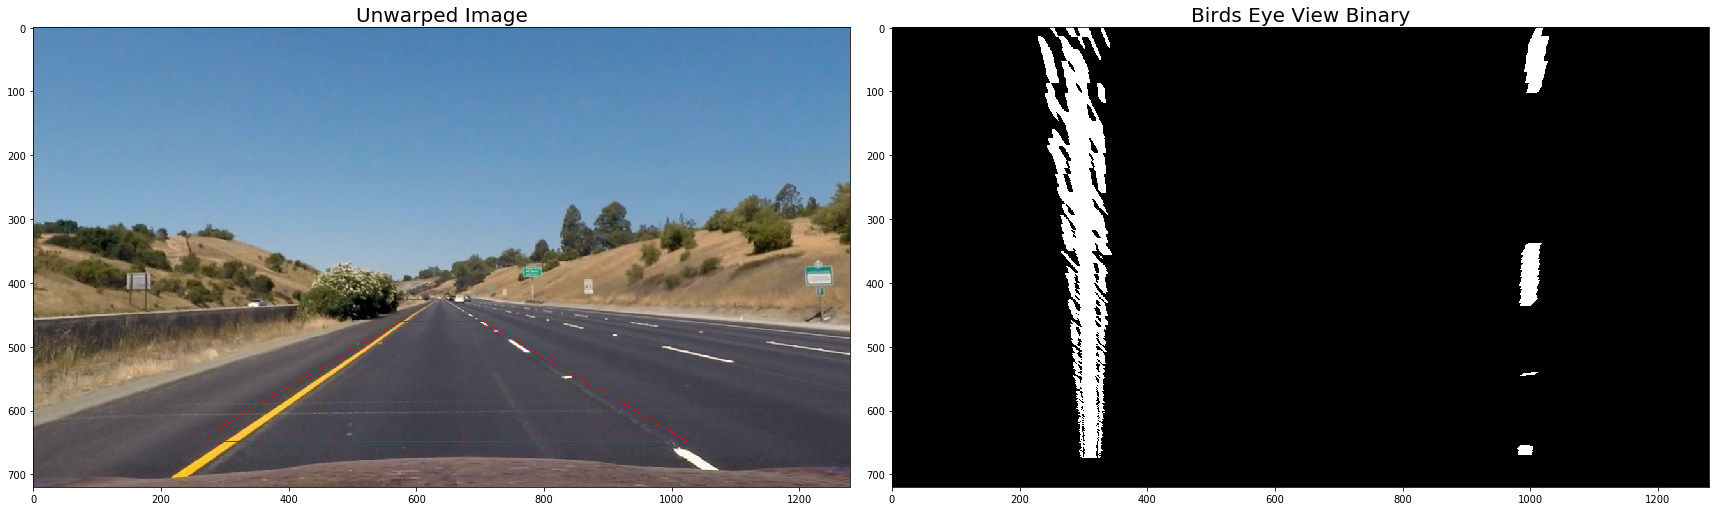

In [9]:
test_im = mpimg.imread('test_images/straight_lines1.jpg')
test_im = cv2.undistort(test_im, mtx, dist, None, mtx)
drawn, warped = transform_n_warp(test_im, M, thresh=True, line=True)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(drawn, cmap='gray')
ax1.set_title('Unwarped Image', fontsize=20)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Birds Eye View Binary', fontsize=20)

## Fit Right and Left Lane Lines

### 1. Histogram to detect lane regions

Text(0.5,1,'Histogram')

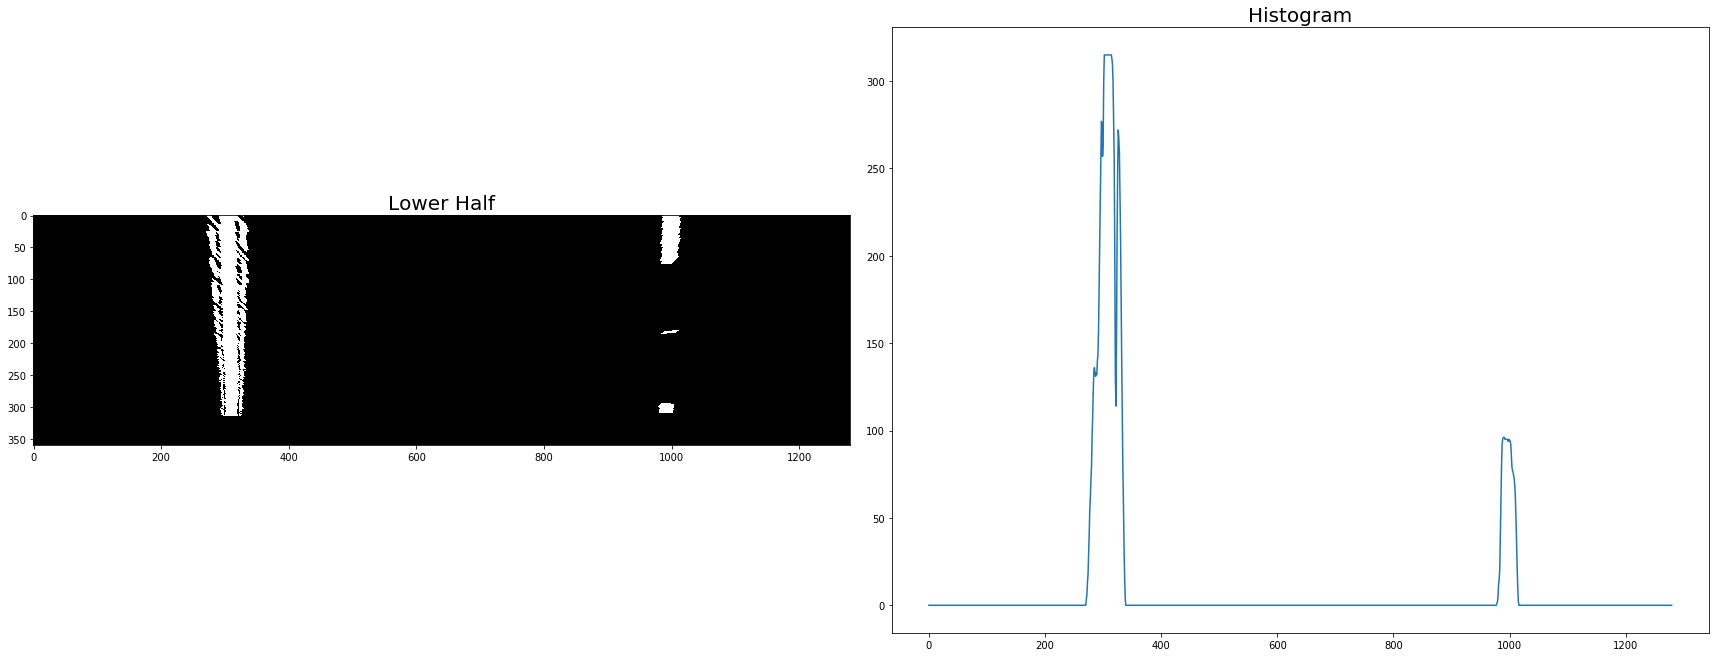

In [10]:
# computing the histogram and plotting
histogram = np.sum(warped[int(warped.shape[0]/2):,:], axis=0)

lower_half = warped[int(warped.shape[0]/2):, :] #lower half of image

f, (ax1, ax2) = plt.subplots(1,2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(lower_half, cmap='gray')
ax1.set_title('Lower Half', fontsize=20)
ax2.plot(histogram)
ax2.set_title('Histogram', fontsize=20)

### 2. implement sliding windows approach

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


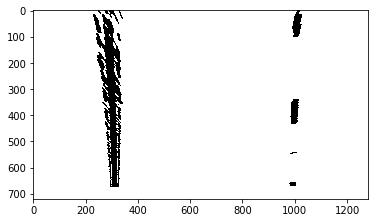

In [11]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((warped, warped, warped))*255

# convert image to integer arrays
out_img = out_img.astype(np.int8)

plt.imshow(out_img)

In [12]:
# Find the peak of the left and right halves of the histogram and those are the starting point for lan
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Number of sliding windows
nwindows = 10

# Height of windows
window_height = np.int(warped.shape[0]/nwindows)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Set the width of the windows +/- margin
margin = 100

# Set minimum number of pixels found to recenter window
minpix = 50

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped.shape[0] - (window+1)*window_height
    win_y_high = warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin

    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 5) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 5) 

    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)


# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# change the colour of nonzero pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [100, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 100]



#### Display the sliding windows on the lanes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5,1,'Binary Image with Nonezero Pixel-Search Windows')

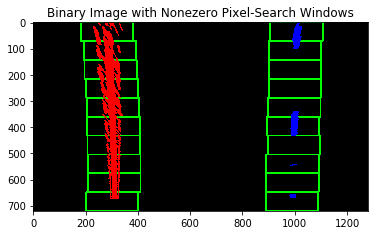

In [13]:
plt.imshow(out_img*255)
plt.title('Binary Image with Nonezero Pixel-Search Windows')

### 3. Change the colour of non-zero pixels to red

Text(0.5,1,'Binary Image with Plot Lines')

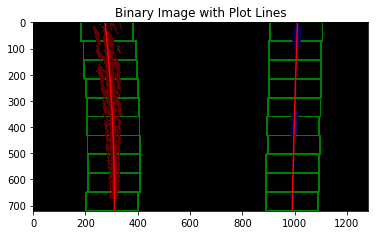

In [14]:
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [100, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 100]

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='red')
plt.plot(right_fitx, ploty, color='red')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.title('Binary Image with Plot Lines')

### 4. Draw the curves on the perspective image

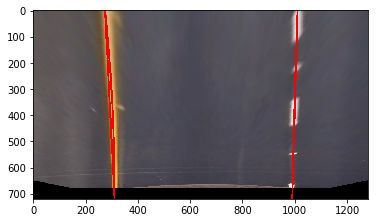

In [15]:
def draw_curves(image, pts):
    img = image.copy()
    img = cv2.polylines(img, [pts], True, (255, 0, 0), thickness=5)
    return img

test_image = test_im
test_image = cv2.undistort(test_image, mtx, dist, None, mtx)
test_image = transform_n_warp(test_image, M, thresh=False, line=False)[1]
left_curves = np.asarray([[left_fitx[i], ploty[i]] for i in range(warped.shape[0])]).astype(np.int32)
right_curves = np.asarray([[right_fitx[i], ploty[i]] for i in range(warped.shape[0])]).astype(np.int32)
img = draw_curves(test_image, left_curves)
img = draw_curves(img, right_curves)
plt.imshow(img)

### 5. Skip the sliding windows step once you know where the lines are


In [16]:
# Skip the sliding windows step once you know where the lines are
binary_warped = transform_n_warp(test_im.copy(), M, thresh=True)[1]

# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

In [17]:
# # Create an image to draw on and an image to show the selection window

out_img = np.dstack((binary_warped, binary_warped, binary_warped))#*255
window_img = np.zeros_like(out_img)

In [18]:
# # # convert image to integer arrays
out_img = out_img.astype(np.int8)
window_img = window_img.astype(np.int8)

# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [100, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 100]

#### Shading lane region

(720, 0)

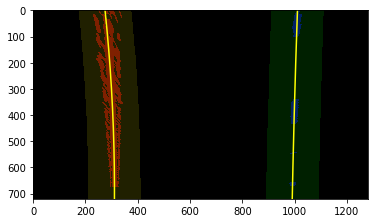

In [19]:
# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (255,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))

# out_img = out_img.astype(np.int8)
result = cv2.addWeighted(out_img, 1, window_img, 0.25, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Curvature and Vehicle Position

#### Determine the curvature of the lane

In [20]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720.0 # meters per pixel in y dimension
xm_per_pix = 3.7/700.0 # meters per pixel in x dimension

def curvature(x, y, xm, ym):
    # Define y-value where we want radius of curvature, corresponding to the bottom of the image
    y_eval = np.max(y)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y*ym, x*xm, 2)
    curvature = ((1 + (2*fit_cr[0]*y_eval*ym + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curvature
    
left_curverad = curvature(left_fitx, ploty, xm_per_pix, ym_per_pix)
right_curverad = curvature(right_fitx, ploty, xm_per_pix, ym_per_pix)

#### Warp the detected lane boundaries on the original image

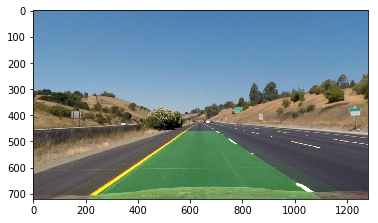

In [21]:
# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

def inverse_warp(image, Minv):
    # Draw the lane onto the warped blank image
    cv2.fillPoly(image, np.int_([pts]), (0,255, 0))
    image=np.uint8(image)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(image, Minv, image.shape[:2][::-1]) 
    newwarp = np.uint8(newwarp)
    return newwarp

newwarp = inverse_warp(result, Minv)

# Combine the result with the original image
final = cv2.addWeighted(test_im, 1, newwarp, 0.5, 0)
plt.imshow(final)

### Visual Display of information

#### Display Lane boundaries, numerical estimation of the lane curvature and vehicle position

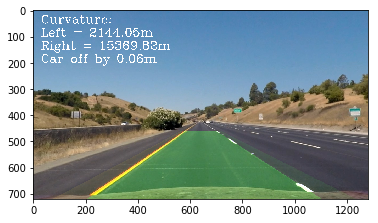

In [22]:
# left line intercept on x axis
left_intcpt = left_fit[0]*img_size[1]**2 + left_fit[1]*img_size[1] + left_fit[2]
# right line intercept on x axis
right_intcpt = right_fit[0]*img_size[1]**2 + right_fit[1]*img_size[1] + right_fit[2]

# calculate lane midpoint
lane_mid = (left_intcpt + right_intcpt)/2.0

car_off = (lane_mid - img_size[0]/2.0)*xm_per_pix

def display_on_frame(image, left_curverad, right_curverad, car_off):
    
    # create display texts on image
    font = cv2.FONT_HERSHEY_COMPLEX
    curve_disp_1 = 'Curvature:'
    curve_disp_2 = 'Left = ' + str(np.round(left_curverad,2)) + 'm'
    curve_disp_3 = 'Right = ' + str(np.round(right_curverad,2)) + 'm'
    off_disp_txt = 'Car off by ' + str(np.round(car_off,2)) + 'm'

    cv2.putText(final, curve_disp_1, (30, 50), font, 1.5, (255,255,255), 2)
    cv2.putText(final, curve_disp_2, (30, 100), font, 1.5, (255,255,255), 2)
    cv2.putText(final, curve_disp_3, (30, 150), font, 1.5, (255,255,255), 2)
    cv2.putText(final, off_disp_txt, (30, 200), font, 1.5, (255,255,255), 2)
    
    return image

final = display_on_frame(final, left_curverad=left_curverad, right_curverad=right_curverad,
                        car_off=car_off)
plt.imshow(final)
plt.imsave('output_images/final_result', final)

## Pipeline for video

In [23]:
# Class to receive the characteristics of each line detection
class Lane():
    def __init__(self):
        # flag for new line
        self.new_line = True
        # was the line detected in the last iteration?
        self.non_detect_tally = 0
        self.non_detect_tally_max = 5
        # self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        self.ploty = []
        
        # camera parameters
        self.dst = np.loadtxt('cam_dist.txt')
        self.mtx = np.loadtxt('cam_mtx.txt')

        self.M = np.loadtxt('M_mat.txt')
        self.Minv = np.loadtxt('Minv_mat.txt')
        
        # windows
        # Set the width of the windows +/- margin
        self.margin = 50

        # Set minimum number of pixels found to recenter window
        self.minpix = 100
        
        # Conversions in x and y from pixels space to meters
        self.ym_per_pix = 30/720.0 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700.0 # meters per pixel in x dimension
    
    def transform_n_warp(self, image, M):
        
        # image size
        img_size = image.shape[:2][::-1]

        # warp image
        image = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)

        # convert to coloured binary image
        image = thresh_bin(image)

        return image

    def update_curves(self, left_fit, right_fit, patience=5):
        """
        update the fit values for n iterations
        """
        self.current_fit = [left_fit, right_fit]
        self.recent_xfitted.append(self.current_fit)
        if len(self.recent_xfitted) > patience:
            self.recent_xfitted.pop(0)
        
        # calculate best fit, mean of last n iterations determined by patience
        self.best_fit = np.mean(self.recent_xfitted, axis=0)
        
        return self.best_fit
        
# find lane function, with sliding window approach
    def find_lane(self, warped):
        """
        return image with lane lines using sliding window approach
        warped: image in bird's eye view
        """

        # Set the width of the windows +/- margin
        margin = self.margin

        # Set minimum number of pixels found to recenter window
        minpix = self.minpix
        
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((warped, warped, warped)).astype(np.int8)#*255
        window_img = np.zeros_like(out_img)
        
        if self.new_line or self.non_detect_tally<self.non_detect_tally_max:
            # we first take a histogram along all the columns in the lower half of the image
            histogram = np.sum(warped[int(warped.shape[0]/2):,:], axis=0)

            # Find the peak of the left and right halves of the histogram
            # These will be the starting point for the left and right lines
            midpoint = np.int(histogram.shape[0]/2)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint

            # Number of sliding windows
            nwindows = 10

            # Height of windows
            window_height = np.int(warped.shape[0]/nwindows)

            # Identify the x and y positions of all nonzero pixels in the image
            nonzero = warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])

            # Current positions to be updated for each window
            leftx_current = leftx_base
            rightx_current = rightx_base

            # Create empty lists to receive left and right lane pixel indices
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = warped.shape[0] - (window+1)*window_height
                win_y_high = warped.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin

                # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
            
            self.new_line = False
            
        else:
            nonzero = warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            
            left_fit, right_fit = self.best_fit
            
            left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
            right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # update global left and right fits
        left_fit, right_fit = self.update_curves(left_fit, right_fit)
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
        
        # save ploty
        self.ploty = ploty
        
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # change the colour of nonzero pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [100, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 100]
        
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
        
        # Calculate the new radii of curvature
        left_curverad = curvature(left_fitx, ploty, self.xm_per_pix, self.ym_per_pix)
        right_curverad = curvature(right_fitx, ploty, self.xm_per_pix, self.ym_per_pix)
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (255,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))

        # out_img = out_img.astype(np.int8)
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)        
        
        #  Warp the detected lane boundaries back onto the original image
        # # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(result, np.int_([pts]), (0,255, 0))
        

        return result, left_curverad, right_curverad
    
    def display_on_frame(self, image, left_curverad, right_curverad, car_off):
        """
        Display texts on image using passed values
        """
        # create display texts on image
        font = cv2.FONT_HERSHEY_COMPLEX
        curve_disp_1 = 'Curvature:'
        curve_disp_2 = 'Left = ' + str(np.round(left_curverad,2)) + 'm'
        curve_disp_3 = 'Right = ' + str(np.round(right_curverad,2)) + 'm' 
        
        off_disp_txt = 'Car off by ' + str(np.round(car_off,2)) + 'm'
        
        cv2.putText(image, curve_disp_1, (30, 50), font, 1.5, (255,255,255), 2)
        cv2.putText(image, curve_disp_2, (30, 100), font, 1.5, (255,255,255), 2)
        cv2.putText(image, curve_disp_3, (30, 150), font, 1.5, (255,255,255), 2)
        cv2.putText(image, off_disp_txt, (30, 200), font, 1.5, (255,255,255), 2)

        return image

    def Lane_find(self, frame):
        """ 
        perform all advanced lane finding process on frame        
        and return processed frame
        """   
        # undistort frame
        frame = cv2.undistort(frame, self.mtx, self.dst, None, self.mtx)
        
        original_frame = np.copy(frame)
        
        # transform image to bird's eye view
        frame = self.transform_n_warp(frame, self.M)
        
        # find lane lines 
        
        frame, left_curverad, right_curverad = self.find_lane(frame)

        img_size = frame.shape[:2]
        
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(frame.astype(np.float32), self.Minv, img_size[::-1]) 
        newwarp = np.uint8(newwarp)

        # Combine the result with the original image
        frame = cv2.addWeighted(original_frame, 1, newwarp, 0.6, 0)
        
        # calculate lane midpoint
        # left line intercept on x axis
        left_fit, right_fit = self.best_fit

        left_intcpt = left_fit[0]*img_size[1]**2 + left_fit[1]*img_size[1] + left_fit[2]

        # right line intercept on x axis
        right_intcpt = right_fit[0]*img_size[1]**2 + right_fit[1]*img_size[1] + right_fit[2]

        lane_mid = (left_intcpt + right_intcpt)/2.0

        car_off = (lane_mid - img_size[1]/2.0)*self.xm_per_pix

        # display visuals on frame
        frame = self.display_on_frame(frame, left_curverad=left_curverad, right_curverad=right_curverad,
                        car_off=car_off)
        
        # return processed frame
        ret_frame = frame
        return ret_frame.astype(np.uint8)

### Video output with Advanced lane detection

In [24]:
from moviepy.editor import VideoFileClip
frame_line = Lane()
vid_output = 'project_solved.mp4'
clip_source = VideoFileClip("project_video.mp4")
vid_clip = clip_source.fl_image(frame_line.Lane_find)
%time vid_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video project_solved.mp4
[MoviePy] Writing video project_solved.mp4


100%|█████████▉| 1260/1261 [04:19<00:00,  4.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_solved.mp4 

CPU times: user 4min 47s, sys: 1min, total: 5min 47s
Wall time: 4min 21s
